In [1]:
# -------------------------------------------------------------
# 1. IMPORT LIBRARIES
# -------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# -------------------------------------------------------------
# 2. LOAD DATA
# -------------------------------------------------------------
load_df = pd.read_csv(
    r"C:\Users\Administrator\v2g\clean_load_data_15min.csv",
    parse_dates=["datetime"],
    index_col="datetime"
)

print("Load data range:", load_df.index.min(), "→", load_df.index.max())

Load data range: 2006-12-16 17:15:00 → 2010-11-26 21:00:00


In [3]:
# -------------------------------------------------------------
# 3. CLEAN DATA (REMOVE NaN & EXTREME OUTLIERS)
# -------------------------------------------------------------
# Make numeric
load_df["load_kw"] = pd.to_numeric(load_df["load_kw"], errors="coerce")

# Replace inf with NaN
load_df = load_df.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN
load_df = load_df.dropna(subset=["load_kw"])

# Clip extreme spikes (VERY IMPORTANT)
low, high = load_df["load_kw"].quantile([0.01, 0.99])
load_df["load_kw"] = load_df["load_kw"].clip(low, high)

print("Remaining NaNs:", load_df["load_kw"].isna().sum())

Remaining NaNs: 0


In [4]:
# -------------------------------------------------------------
# 4. SCALE CLEANED DATA
# -------------------------------------------------------------
scaler = MinMaxScaler()
load_df["load_scaled"] = scaler.fit_transform(load_df[["load_kw"]])

# Final check
print("Any NaN after scaling:", load_df["load_scaled"].isna().sum())

data = load_df["load_scaled"].values

Any NaN after scaling: 0


In [5]:
# -------------------------------------------------------------
# 5. CREATE SEQUENCES
# -------------------------------------------------------------
def create_sequences(data, seq_len=96):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 96
X, y = create_sequences(data, SEQ_LEN)
X = X.reshape((X.shape[0], X.shape[1], 1))

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (136543, 96, 1)
y shape: (136543,)


In [6]:
# -------------------------------------------------------------
# 6. TRAIN / TEST SPLIT
# -------------------------------------------------------------
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (109234, 96, 1)
Test size: (27309, 96, 1)


In [7]:
# -------------------------------------------------------------
# 7. BUILD STABLE LSTM MODEL (NO NaN TRAINING)
# -------------------------------------------------------------
optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)  # gradient clipping

model = Sequential([
    Input(shape=(SEQ_LEN, 1)),

    LSTM(128, return_sequences=True, recurrent_dropout=0.1),
    Dropout(0.2),

    LSTM(64, return_sequences=False, recurrent_dropout=0.1),
    Dropout(0.2),

    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(
    loss="mse",
    optimizer=optimizer
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [8]:
# -------------------------------------------------------------
# 8. TRAIN MODEL (SHOULD NOT SHOW NaN NOW)
# -------------------------------------------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    batch_size=128,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/40
769/769 ━━━━━━━━━━━━━━━━━━━━ 169s 214ms/step - loss: 0.0203 - val_loss: 0.0153 - learning_rate: 5.0000e-04
Epoch 2/40
769/769 ━━━━━━━━━━━━━━━━━━━━ 170s 221ms/step - loss: 0.0148 - val_loss: 0.0148 - learning_rate: 5.0000e-04
Epoch 3/40
769/769 ━━━━━━━━━━━━━━━━━━━━ 170s 221ms/step - loss: 0.0145 - val_loss: 0.0147 - learning_rate: 5.0000e-04
Epoch 4/40
769/769 ━━━━━━━━━━━━━━━━━━━━ 178s 231ms/step - loss: 0.0144 - val_loss: 0.0148 - learning_rate: 5.0000e-04
Epoch 5/40
769/769 ━━━━━━━━━━━━━━━━━━━━ 171s 222ms/step - loss: 0.0144 - val_loss: 0.0146 - learning_rate: 5.0000e-04
Epoch 6/40
769/769 ━━━━━━━━━━━━━━━━━━━━ 173s 225ms/step - loss: 0.0143 - val_loss: 0.0144 - learning_rate: 5.0000e-04
Epoch 7/40
769/769 ━━━━━━━━━━━━━━━━━━━━ 182s 237ms/step - loss: 0.0142 - val_loss: 0.0145 - learning_rate: 5.0000e-04
Epoch 8/40
769/769 ━━━━━━━━━━━━━━━━━━━━ 179s 233ms/step - loss: 0.0142 - val_loss: 0.0143 - learning_rate: 5.0000e-04
Epoch 9/40
769/769 ━━━━━━━━━━━━━━━━━━━━ 180s 234ms/step 

In [9]:
# -------------------------------------------------------------
# 9. PREDICT
# -------------------------------------------------------------
y_pred_scaled = model.predict(X_test)

# Check NaN in predictions
print("NaN in predictions:", np.isnan(y_pred_scaled).sum())

# Inverse scaling
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

854/854 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step
NaN in predictions: 0


In [10]:
# -------------------------------------------------------------
# 10. METRICS
# -------------------------------------------------------------
mse = mean_squared_error(y_test_real, y_pred)
mae = mean_absolute_error(y_test_real, y_pred)
r2 = r2_score(y_test_real, y_pred)

print("\nModel Performance:")
print("MSE:", mse)
print("MAE:", mae)
print("R²:", r2)


Model Performance:
MSE: 0.2089033992908005
MAE: 0.2857581935930664
R²: 0.6913736856022186


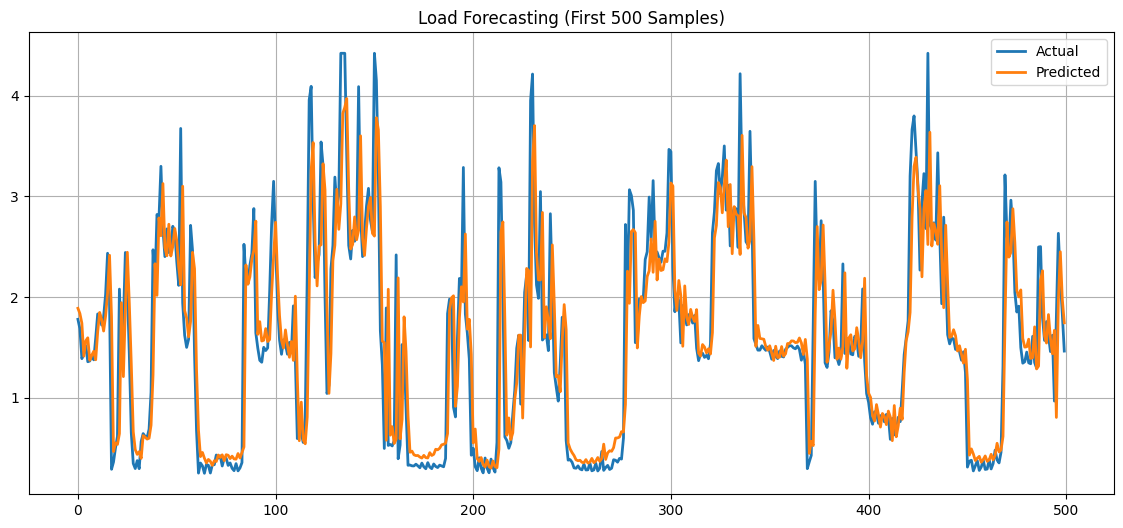

In [11]:
# -------------------------------------------------------------
# 11. PLOT RESULTS
# -------------------------------------------------------------
plt.figure(figsize=(14,6))
plt.plot(y_test_real[:500], label="Actual", linewidth=2)
plt.plot(y_pred[:500], label="Predicted", linewidth=2)
plt.title("Load Forecasting (First 500 Samples)")
plt.legend()
plt.grid(True)
plt.show()